# First analysis of geographical data

For performance reasons only may data is used.

In [256]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium
from folium import plugins
from folium.plugins import HeatMap

In [258]:
chicago_data = pd.read_csv("../chicago_2016.csv")
chicago_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3595383 entries, 0 to 3595382
Data columns (total 8 columns):
 #   Column              Dtype         
---  ------              -----         
 0   start_time          datetime64[ns]
 1   end_time            datetime64[ns]
 2   start_station_id    int64         
 3   end_station_id      int64         
 4   start_station_name  object        
 5   end_station_name    object        
 6   bike_id             int64         
 7   user_type           object        
dtypes: datetime64[ns](2), int64(3), object(3)
memory usage: 219.4+ MB


In [280]:
chicago_data.head()

,start_time,end_time,start_station_id,end_station_id,start_station_name,end_station_name,bike_id,user_type
0,2016-03-31 23:53:00,2016-04-01 00:07:00,344,458,Ravenswood Ave & Lawrence Ave,Broadway & Thorndale Ave,155,Subscriber
1,2016-03-31 23:46:00,2016-03-31 23:57:00,128,213,Damen Ave & Chicago Ave,Leavitt St & North Ave,4831,Subscriber
2,2016-03-31 23:42:00,2016-03-31 23:46:00,350,210,Ashland Ave & Chicago Ave,Ashland Ave & Division St,4232,Subscriber
3,2016-03-31 23:37:00,2016-03-31 23:55:00,303,458,Broadway & Cornelia Ave,Broadway & Thorndale Ave,3464,Subscriber
4,2016-03-31 23:33:00,2016-03-31 23:37:00,334,329,Lake Shore Dr & Belmont Ave,Lake Shore Dr & Diversey Pkwy,1750,Subscriber


In [281]:
coordinates = pd.read_csv("../Divvy_Stations_2016_Q1Q2.csv")
start_count = chicago_data["start_station_name"].value_counts()
end_count = chicago_data["end_station_name"].value_counts()

In [282]:
#aggregate; started trip = ended trip = 1 activity
activity = start_count.to_frame().merge(end_count,left_on=start_count.index,right_on=end_count.index,how="outer")
activity = activity.rename(columns={"key_0":"station_name","end_station_name":"finished_trips","start_station_name":"started_trips"})
#set null values to 0
activity = activity.fillna(value=0)
#add activity column
activity["activities"] = activity["finished_trips"]+activity["started_trips"]
activity.head()

#add coordinates to stations
coordinates["ziped_coords"] = list(zip(coordinates["latitude"],coordinates["longitude"]))
activity = activity.merge(coordinates["ziped_coords"].to_frame(),how = "left",left_on=activity["station_name"],right_on=coordinates["name"])
activity = activity.drop(columns=["key_0"])
#drop stations without location data !!! maybe the data is in other datasets
activity = activity.dropna(axis=0)
activity = activity.sort_values(by="activities",ascending=False)
activity.head(3)

,station_name,started_trips,finished_trips,activities,ziped_coords
0,Streeter Dr & Grand Ave,90042,99495,189537,"(41.892278000000005, -87.612043)"
1,Lake Shore Dr & Monroe St,51090,48583,99673,"(41.880958, -87.616743)"
2,Theater on the Lake,47927,51281,99208,"(41.926277, -87.630834)"


In [283]:
#stations; size->logarithmic number of started tours
#red ones have more started trips than finished trips
#blue ones have more finished trips than started ones
log_map = folium.Map(location=(41.873222041337044, -87.62596070777431),tiles='OpenStreetMap',zoom_start=11, control_scale=True, max_zoom=20)

for index, row in activity.iterrows():
    diff_color = "red" if row["started_trips"] > row["finished_trips"] else "blue"
    folium.CircleMarker(radius=np.power(np.log(row["activities"])/4,1.5), location=row["ziped_coords"], popup=row["station_name"], color=diff_color, fill_color=diff_color,weight=1).add_to(log_map)

#prevent jupyter notebook from cutting of map height
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height:unset !important; }</style>"))

log_map

<BarContainer object of 50 artists>

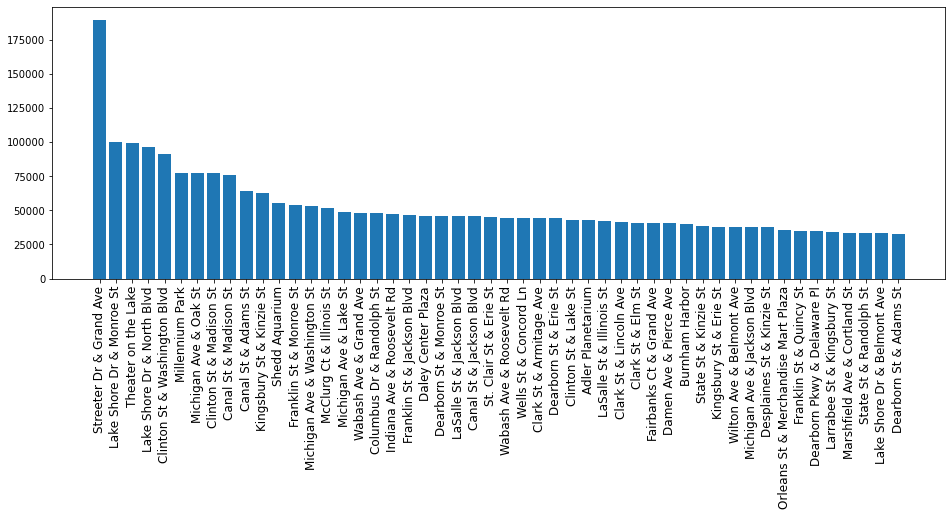

In [278]:
#stations by most activity (started and ended trips)
fig, ax = plt.subplots(figsize=[16,5])
plt.setp(ax.xaxis.get_majorticklabels(),rotation=90,fontsize=12)
ax.bar(activity["station_name"].iloc[:50], activity["activities"].iloc[:50])

<BarContainer object of 50 artists>

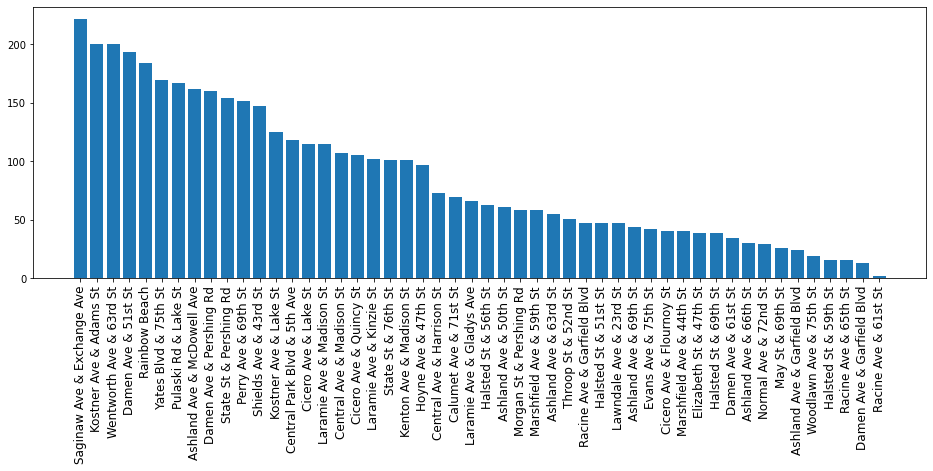

In [284]:
#stations by least activity (started and ended trips)
fig, ax = plt.subplots(figsize=[16,5])
plt.setp(ax.xaxis.get_majorticklabels(),rotation=90,fontsize=12)
ax.bar(activity["station_name"].iloc[-50:], activity["activities"].iloc[-50:])

In [285]:
#most an least used stations on a map
#blue -> least used
#red -> most used
log_map = folium.Map(location=(41.873222041337044, -87.62596070777431),tiles='OpenStreetMap',zoom_start=11, control_scale=True, max_zoom=20)
#add most used
for index, row in activity.iloc[:50].iterrows():
    folium.CircleMarker(radius=5, location=row["ziped_coords"], popup=row["station_name"], color="red", fill_color="red").add_to(log_map)
#add least used
for index, row in activity.iloc[-50:].iterrows():
    folium.CircleMarker(radius=5, location=row["ziped_coords"], popup=row["station_name"], color="blue", fill_color="blue").add_to(log_map)
log_map